# Geometry investigation

The goal of this notebook is to see how well a PINN trained on a given geometry can generalize to a different geometry

We will take a model trained on x;0-1(20),y;0-1(20),t;0-5(0.005)

This model will then be used to predict fluid flow for two different shaped geometries:

- x; 0-1(20)   y; 0-0.5(10)
- x; 0-0.5(10) y; 0-1(20)

In [1]:
from cfdpinn.args import parse_args
import sys
import torch
from cfdpinn.geometry import setup_geom
from cfdpinn.pinns import predict_fluid
from cfdpinn.preprocess import merge_features
from pickle import load

In [2]:
pinn = torch.load("/Users/harry/pinns/models/tmp-2d-ns-pinn-1epochs-lr0.001-adam-cavity-nu0.01-u1-20x20.pt")

In [3]:
sys.argv = [
    "program-name",
    "--no-train",
    "--startx",
    "0",
    "--endx",
    "1",
    "--numx",
    "20",
    "--starty",
    "0",
    "--endy",
    "0.5",
    "--numy",
    "10",
    "--start-time",
    "0",
    "--end-time",
    "5",
    "--sim-dt",
    "0.001",
    "--load-dt",
    "0.005"
]

args_20x10 = parse_args()
geom_20x10 = setup_geom(args_20x10)


#################
##  CFD PINN   ##
#################

Setting up geometry...
	Geometry setup completed



In [4]:
data = dict()
data["scaler"] = load(open("/Users/harry/pinns/models/scaler.pkl","rb"))

data = merge_features(data,geom_20x10)
data = predict_fluid(data,pinn,geom_20x10,args_20x10)

Prediction of fluid properties...
'inference' wall-time (seconds): 0.063

	Fluid properties prediction complete



In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

In [7]:
#Using pred as a dummy to get this working
data["u"] = data["u_pred"] * 1.1
data["u_resid"] = abs(data["u"] -  data["u_pred"])

data["v"] = data["v_pred"] * 1.1
data["v_resid"] = abs(data["v"] -  data["v_pred"])

data["p"] = data["p_pred"] * 1.1
data["p_resid"] = data["p"] -  data["p_pred"]

data[f"u_mag"] = np.sqrt(
            data[f"u"].astype(np.double)**2 + \
            data[f"v"].astype(np.double)**2
        ).astype(float)

data[f"u_mag_pred"] = np.sqrt(
            data[f"u_pred"].astype(np.double)**2 + \
            data[f"v_pred"].astype(np.double)**2
        ).astype(float)

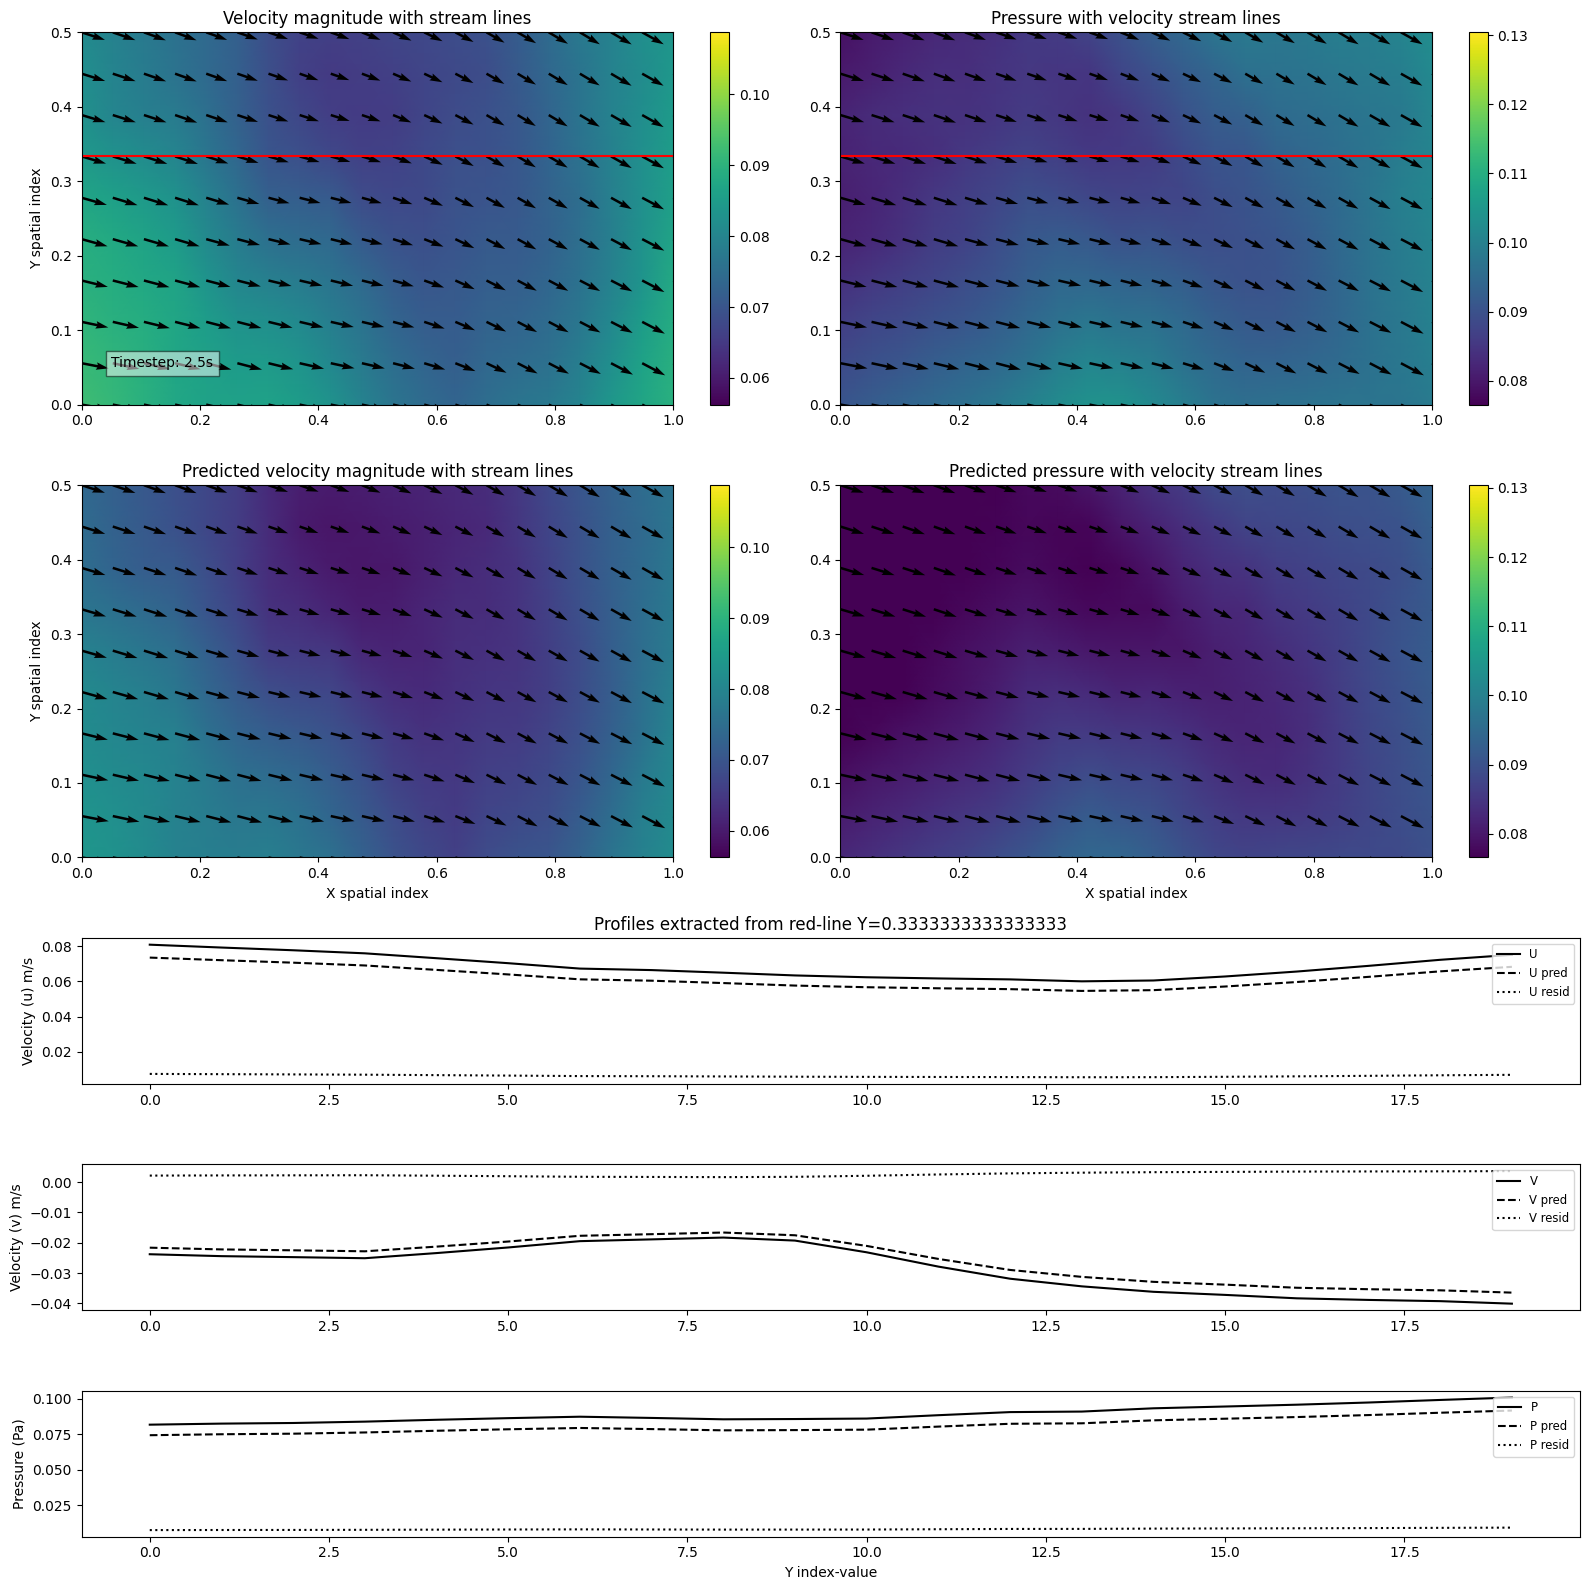

In [14]:
#Static plot
umin=data["u"].min()
umax=data["u"].max()
pmin=data["p"].min()
pmax=data["p"].max()

y_index = 6
y_value = geom_20x10["grid2d_y"][y_index][0]
timestep_index = 500

fig, axs = plt.subplot_mosaic(
    [['u_mag_quiv', 'p_quiv'], 
     ['u_mag_quiv', 'p_quiv'],
     ['u_mag_quiv_pred', 'p_quiv_pred'], 
     ['u_mag_quiv_pred', 'p_quiv_pred'], 
     ['u', 'u'],
     ['v', 'v'],
     ['p', 'p']
     ],layout='tight')

fig.set_figwidth(16)
fig.set_figheight(16)

#U magnitude with quiver plot
u_mag_quiv_pcol = axs["u_mag_quiv"].pcolormesh(
        geom_20x10["grid2d_x"],geom_20x10["grid2d_y"],
        data[f"u_mag"][timestep_index,:,:],
        shading='gouraud',
        vmin=umin, vmax=umax)

u_mag_quiv_quiv = axs["u_mag_quiv"].quiver(
            geom_20x10["grid2d_x"],geom_20x10["grid2d_y"], 
            data[f"u"][timestep_index,:,:],
            data[f"v"][timestep_index,:,:])

plt.colorbar(u_mag_quiv_pcol, ax=axs["u_mag_quiv"])

#Show index used for extracting profile
axs["u_mag_quiv"].axhline(y = y_value, color = 'r', linestyle = "solid")

axs["u_mag_quiv"].set_ylabel("Y spatial index")
axs["u_mag_quiv"].set_title("Velocity magnitude with stream lines")
axs["u_mag_quiv"].text(0.05,0.05,f"Timestep: 2.5s",bbox={'facecolor':'w', 'alpha':0.5})

#Pressure with quiver plot
p_quiv_pcol = axs["p_quiv"].pcolormesh(
        geom_20x10["grid2d_x"],geom_20x10["grid2d_y"],
        data[f"p"][timestep_index,:,:],
        shading='gouraud',
        vmin=pmin, vmax=pmax)

p_quiv_quiv = axs["p_quiv"].quiver(
            geom_20x10["grid2d_x"],geom_20x10["grid2d_y"], 
            data[f"u"][timestep_index,:,:],
            data[f"v"][timestep_index,:,:])

plt.colorbar(p_quiv_pcol, ax=axs["p_quiv"])
axs["p_quiv"].axhline(y = y_value, color = 'r', linestyle = "solid")
axs["p_quiv"].set_title("Pressure with velocity stream lines")

#PREDICTIONS
u_mag_quiv_pred_pcol = axs["u_mag_quiv_pred"].pcolormesh(
        geom_20x10["grid2d_x"],geom_20x10["grid2d_y"],
        data[f"u_mag_pred"][timestep_index,:,:],
        shading='gouraud',
        vmin=umin, vmax=umax)

u_mag_quiv_pred_quiv = axs["u_mag_quiv_pred"].quiver(
            geom_20x10["grid2d_x"],geom_20x10["grid2d_y"], 
            data[f"u_pred"][timestep_index,:,:],
            data[f"v_pred"][timestep_index,:,:])

plt.colorbar(u_mag_quiv_pred_pcol, ax=axs["u_mag_quiv_pred"])

#Show index used for extracting profile

axs["u_mag_quiv_pred"].set_xlabel("X spatial index")
axs["u_mag_quiv_pred"].set_ylabel("Y spatial index")
axs["u_mag_quiv_pred"].set_title("Predicted velocity magnitude with stream lines")

#Pressure with quiver plot
p_quiv_pcol_pred = axs["p_quiv_pred"].pcolormesh(
        geom_20x10["grid2d_x"],geom_20x10["grid2d_y"],
        data[f"p_pred"][timestep_index,:,:],
        shading='gouraud',
        vmin=pmin, vmax=pmax)

p_quiv_quiv_pred = axs["p_quiv_pred"].quiver(
            geom_20x10["grid2d_x"],geom_20x10["grid2d_y"], 
            data[f"u_pred"][timestep_index,:,:],
            data[f"v_pred"][timestep_index,:,:])

plt.colorbar(p_quiv_pcol_pred, ax=axs["p_quiv_pred"])

axs["p_quiv_pred"].set_xlabel("X spatial index")
axs["p_quiv_pred"].set_title("Predicted pressure with velocity stream lines")

#U at x=0.8
axs["u"].plot(data["u"][timestep_index,y_index,:],linestyle="solid", linewidth=1.5, color='black', label='U')
axs["u"].plot(data["u_pred"][timestep_index,y_index,:],linestyle="dashed", linewidth=1.5, color='black', label='U pred')
axs["u"].plot(data["u_resid"][timestep_index,y_index,:],linestyle="dotted", linewidth=1.5, color='black', label='U resid')
axs["u"].legend(fontsize="small", loc="upper right")
axs["u"].set_ylabel("Velocity (u) m/s")
axs["u"].set_title(f"Profiles extracted from red-line Y={y_value}")

axs["v"].plot(data["v"][timestep_index,y_index,:],linestyle="solid", linewidth=1.5, color='black', label='V')
axs["v"].plot(data["v_pred"][timestep_index,y_index,:],linestyle="dashed", linewidth=1.5, color='black', label='V pred')
axs["v"].plot(data["v_resid"][timestep_index,y_index,:],linestyle="dotted", linewidth=1.5, color='black', label='V resid')
axs["v"].legend(fontsize="small", loc="upper right")
axs["v"].set_ylabel("Velocity (v) m/s")

axs["p"].plot(data["p"][timestep_index,y_index,:],linestyle="solid", linewidth=1.5, color='black', label='P')
axs["p"].plot(data["p_pred"][timestep_index,y_index,:],linestyle="dashed", linewidth=1.5, color='black', label='P pred')
axs["p"].plot(data["p_resid"][timestep_index,y_index,:],linestyle="dotted", linewidth=1.5, color='black', label='P resid')
axs["p"].legend(fontsize="small", loc="upper right")
axs["p"].set_xlabel("Y index-value")
axs["p"].set_ylabel("Pressure (Pa)")


plt.show()

In [84]:
resid_as_percent = 100*((data["u_resid"].mean()) / (data["u"].mean()))
print(f"Residual as a % of simulated data: {resid_as_percent:0.2f}%")

Residual as a % of simulated data: 9.09%
